## 🧠 YOLOv5 - Detecção de Objetos Cortantes
# Este notebook foi treinado paara identificar faca, tesouras, e outros objetos cortantes de diferentes tipos.

 - Depois da celula do treinamento, há um trecho onde é possivel realizar o save do ultimo treino, e uma celula abaixo onde é possivel carregar o ultimo treinamento,.

In [ ]:
# Etapa 1: Clonar o repositório do YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [ ]:
# Etapa 2: Montar o Google Drive (opcional, para usar dados do seu drive)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset já está no Google Drive, então NÃO precisa extrair nada

dataset_path = '/content/drive/MyDrive/hacktonFIAP/'  # ou ajuste conforme sua pasta

# Verifique se as pastas existem
!ls "$dataset_path"


ann  dataset  img  labels


## Convertendo os arquivos Json em .txt para que o YOLO possar processar.


In [ ]:
import os
import json

# Caminhos
json_dir = '/content/drive/MyDrive/hacktonFIAP/ann'
output_dir = '/content/drive/MyDrive/hacktonFIAP/labels'

# Cria o diretório de saída se não existir
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(json_dir, filename)

        with open(json_path, 'r') as f:
            data = json.load(f)

        img_width = data.get("size", {}).get("width", 1)
        img_height = data.get("size", {}).get("height", 1)

        yolo_lines = []

        for obj in data.get("objects", []):
            if obj.get("geometryType") != "rectangle":
                continue  # ignorar se não for bbox

            label = obj.get("classTitle", "").lower()
            class_id = 0 if label == "knife" else 1  # Adapte aqui se tiver mais classes

            x_min, y_min = obj["points"]["exterior"][0]
            x_max, y_max = obj["points"]["exterior"][1]

            x_center = (x_min + x_max) / 2.0 / img_width
            y_center = (y_min + y_max) / 2.0 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height

            yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
            yolo_lines.append(yolo_line)

        # Salvar .txt com mesmo nome da imagem
        output_filename = os.path.splitext(filename)[0].replace('.jpg', '') + '.txt'
        output_path = os.path.join(output_dir, output_filename)

        with open(output_path, 'w') as f:
            f.write("\\n".join(yolo_lines))

print("✅ Conversão concluída! Arquivos salvos em:", output_dir)


✅ Conversão concluída! Arquivos salvos em: /content/drive/MyDrive/hacktonFIAP/labels


In [ ]:
!mkdir -p /content/dataset/all/images
!mkdir -p /content/dataset/all/labels

!cp -r /content/drive/MyDrive/hacktonFIAP/img/* /content/dataset/all/images/
!cp -r /content/drive/MyDrive/hacktonFIAP/labels/* /content/dataset/all/labels/


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

img_dir = '/content/dataset/all/images'
label_dir = '/content/dataset/all/labels'
base_dir = '/content/dataset'

for split in ['train', 'valid']:
    os.makedirs(f"{base_dir}/{split}/images", exist_ok=True)
    os.makedirs(f"{base_dir}/{split}/labels", exist_ok=True)

# Filtrar imagens com labels válidas
images = [
    f for f in os.listdir(img_dir)
    if f.endswith('.jpg') and os.path.exists(os.path.join(label_dir, f.replace('.jpg', '.txt')))
]

train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

def move_split(img_list, split):
    for img in img_list:
        label = img.replace('.jpg', '.txt')
        shutil.copy(os.path.join(img_dir, img), f"{base_dir}/{split}/images/{img}")
        shutil.copy(os.path.join(label_dir, label), f"{base_dir}/{split}/labels/{label}")

move_split(train_imgs, 'train')
move_split(val_imgs, 'valid')

print("✅ Dataset LOCAL organizado com sucesso!")


✅ Dataset LOCAL organizado com sucesso!


não executar o trecho a baixo  (JÁ ESTA SEPARADO EM TRAIN X TEST)


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Caminhos de origem
img_dir = '/content/drive/MyDrive/hacktonFIAP/img'
label_dir = '/content/drive/MyDrive/hacktonFIAP/labels'

# Diretórios de destino
base_dir = '/content/drive/MyDrive/hacktonFIAP/dataset'
for split in ['train', 'valid']:
    os.makedirs(f"{base_dir}/{split}/images", exist_ok=True)
    os.makedirs(f"{base_dir}/{split}/labels", exist_ok=True)

# Listar imagens disponíveis
# Listar imagens que possuem anotação correspondente
images = [
    f for f in os.listdir(img_dir)
    if f.endswith('.jpg') and os.path.exists(os.path.join(label_dir, f.replace('.jpg', '.txt')))
]

train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

# Função para mover imagens e labels
def move_split(img_list, split):
    for img in img_list:
        label = img.replace('.jpg', '.txt')
        shutil.copy(os.path.join(img_dir, img), f"{base_dir}/{split}/images/{img}")
        shutil.copy(os.path.join(label_dir, label), f"{base_dir}/{split}/labels/{label}")

# Executar a separação
move_split(train_imgs, 'train')
move_split(val_imgs, 'valid')

print("✅ Dataset organizado em treino e validação!")


KeyboardInterrupt: 

In [ ]:
dataset_yaml = '''
train: /content/drive/MyDrive/hacktonFIAP/dataset/train/images
val: /content/drive/MyDrive/hacktonFIAP/dataset/valid/images

nc: 1
names: ['knife']
'''

with open('/content/yolov5/data.yaml', 'w') as f:
    f.write(dataset_yaml)

print("✅ Arquivo dataset.yaml criado com sucesso!")


✅ Arquivo dataset.yaml criado com sucesso!


In [ ]:
# Etapa 5: Iniciar o treinamento
!python train.py --img 640 --batch 16 --epochs 50 --data /content/yolov5/data.yaml --weights yolov5s.pt --name visao-cortante


A saída de streaming foi truncada nas últimas 5000 linhas.
      25/49      4.75G    0.02381    0.00963          0         32        640:  91% 92/101 [01:15<00:09,  1.01s/it]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      25/49      4.75G    0.02382   0.009618          0         33        640:  92% 93/101 [01:16<00:08,  1.04s/it]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      25/49      4.75G    0.02383   0.009622          0         39        640:  93% 94/101 [01:16<00:05,  1.22it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      25/49      4.75G    

## SALVA O MODELO NO GOOGLE DRIVE:

In [ ]:
!cp /content/yolov5/runs/train/visao-cortante/weights/best.pt /content/drive/MyDrive/modelo_faca.pt


## CARREGA O ULTIMO MODELO SALVO

In [ ]:
import torch

# Caminho para o modelo salvo no Drive
modelo_path = '/content/drive/MyDrive/modelo_faca.pt'

# Carregar modelo customizado do YOLOv5
model = torch.hub.load('ultralytics/yolov5', 'custom', path=modelo_path)

# Opcional: definir limite de confiança mínima para detecção
model.conf = 0.4

print("✅ Modelo carregado com sucesso a partir do Drive!")


## Teste de Faca webcan com marcação em real time



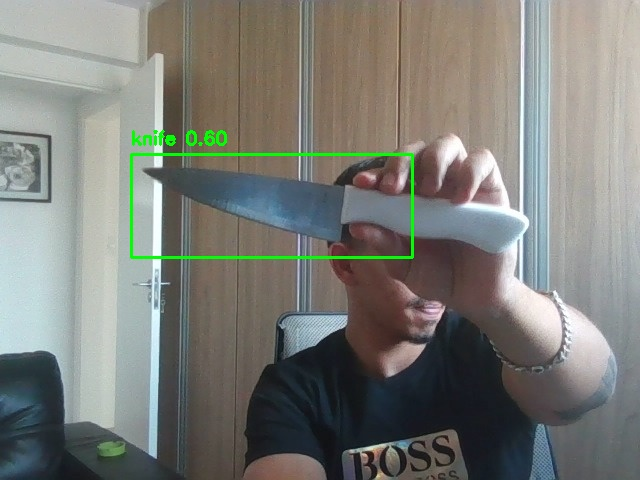

In [ ]:
# 📦 Importações
import cv2
import torch
import numpy as np
import os
import smtplib
from base64 import b64decode
from email.message import EmailMessage
from IPython.display import display, Javascript, clear_output, Image
from google.colab.output import eval_js
from google.colab import output

# 🚀 Carrega o modelo YOLOv5 treinado
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/visao-cortante/weights/best.pt')
model.conf = 0.4  # confiança mínima

# 📁 Pasta onde as imagens detectadas serão salvas
save_dir = '/content/live_Images_detected'
os.makedirs(save_dir, exist_ok=True)
frame_count = 0

# 📧 Função de envio de alerta por GMAIL (com senha de app)
def enviar_alerta_email(imagem_path):
    EMAIL_ORIGEM = 'farofinha3333@gmail.com'
    SENHA = ''
    EMAIL_DESTINO = 'ramon.sancha@icloud.com'

    msg = EmailMessage()
    msg['Subject'] = '🚨 Alerta de Faca Detectada'
    msg['From'] = EMAIL_ORIGEM
    msg['To'] = EMAIL_DESTINO
    msg.set_content('⚠️ Uma faca foi detectada pela câmera. Verifique a imagem em anexo.')

    try:
        with open(imagem_path, 'rb') as f:
            img_data = f.read()
            msg.add_attachment(img_data, maintype='image', subtype='jpeg', filename='alerta.jpg')
        print("[DEBUG] Imagem anexada com sucesso!")
    except Exception as e:
        print("❌ Erro ao anexar imagem:", e)
        return

    try:
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
            smtp.login(EMAIL_ORIGEM, SENHA)
            smtp.send_message(msg)
        print("✅ Alerta enviado com sucesso!")
    except Exception as e:
        print("❌ Falha ao enviar o e-mail:", e)


# 📸 Processamento do frame da webcam
def handle_frame(image_data):
    global frame_count
    binary = b64decode(image_data.split(',')[1])
    np_arr = np.frombuffer(binary, np.uint8)
    img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

    results = model(img)

    for *xyxy, conf, cls in results.xyxy[0]:
        x1, y1, x2, y2 = map(int, xyxy)
        label = f'{model.names[int(cls)]} {conf:.2f}'
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    filename = f'{save_dir}/frame_{frame_count}.jpg'
    cv2.imwrite(filename, img)

    if len(results.xyxy[0]) > 0:
        print("🔪 Faca detectada! Enviando alerta...")
        enviar_alerta_email(filename)

    frame_count += 1
    clear_output(wait=True)
    display(Image(filename))

# 📲 Interface JS para capturar imagem via webcam
def capture_loop():
    js = Javascript('''
    async function captureLoop() {
      while (true) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Capturar próximo frame';
        capture.style.fontSize = '20px';
        capture.style.padding = '10px 20px';
        capture.style.marginTop = '20px';
        capture.style.background = '#4CAF50';
        capture.style.color = 'white';
        capture.style.border = 'none';
        capture.style.borderRadius = '5px';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        video.style.marginTop = '10px';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getTracks().forEach(track => track.stop());
        div.remove();

        const imageData = canvas.toDataURL('image/jpeg');
        google.colab.kernel.invokeFunction('notebook.handle_frame', [imageData], {});
      }
    }
    captureLoop();
    ''')
    display(js)

# 🔁 Registra a função no Colab e inicia
output.register_callback('notebook.handle_frame', handle_frame)
capture_loop()


REGISTRO DA ULTIMA IMAGEM SALVA

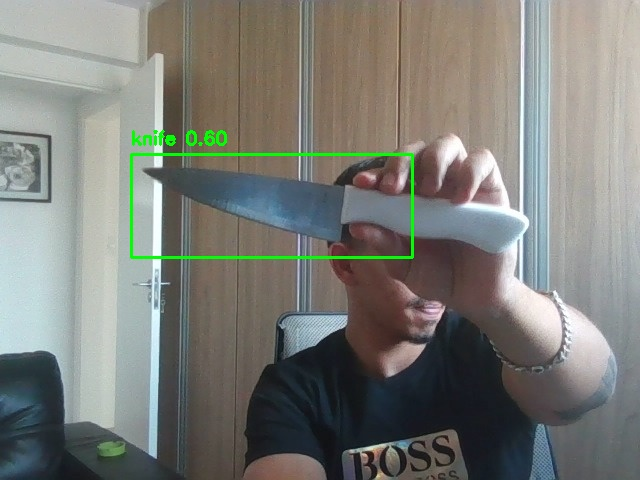

In [ ]:
from IPython.display import Image as ImgTest
ImgTest('/content/live_Images_detected/frame_0.jpg')  # ou o último frame salvo


**BOTÃO DE ENVIO MANUAL DE E-MAIL**

In [ ]:
enviar_alerta_email('/content/live_Images_detected/frame_0.jpg')


[DEBUG] Imagem anexada com sucesso!
✅ Alerta enviado com sucesso!


## TESTE POR VIDEO OU FOTO LOCAL


In [ ]:
import cv2
import torch
import smtplib
from email.message import EmailMessage
import os

# 🚀 Carrega o modelo YOLOv5 treinado
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/visao-cortante/weights/best.pt')
model.conf = 0.4

# 📧 Função para envio do alerta
def enviar_alerta_email(imagem_path):
    EMAIL_ORIGEM = 'farofinha3333@gmail.com'
    SENHA = ''
    EMAIL_DESTINO = 'ramon.sancha@icloud.com'


    msg = EmailMessage()
    msg['Subject'] = '🚨 Faca detectada em vídeo'
    msg['From'] = EMAIL_ORIGEM
    msg['To'] = EMAIL_DESTINO
    msg.set_content('⚠️ Uma faca foi detectada em um vídeo. Veja a imagem em anexo.')

    try:
        with open(imagem_path, 'rb') as f:
            msg.add_attachment(f.read(), maintype='image', subtype='jpeg', filename='alerta_video.jpg')
    except Exception as e:
        print("❌ Erro ao anexar imagem:", e)
        return

    try:
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
            smtp.login(EMAIL_ORIGEM, SENHA)
            smtp.send_message(msg)
        print("✅ E-mail enviado com sucesso!")
    except Exception as e:
        print("❌ Erro ao enviar e-mail:", e)

# 🎥 Função para processar o vídeo
def processar_video(caminho_video):
    cap = cv2.VideoCapture(caminho_video)
    frame_count = 0
    alerta_enviado = False
    save_dir = "/content/frames_detectados"
    os.makedirs(save_dir, exist_ok=True)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)

        if len(results.xyxy[0]) > 0 and not alerta_enviado:
            # desenha a detecção no frame
            for *xyxy, conf, cls in results.xyxy[0]:
                x1, y1, x2, y2 = map(int, xyxy)
                label = f'{model.names[int(cls)]} {conf:.2f}'
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # salva o frame
            frame_path = f"{save_dir}/frame_{frame_count}.jpg"
            cv2.imwrite(frame_path, frame)

            # envia alerta
            enviar_alerta_email(frame_path)
            alerta_enviado = True  # só envia 1 vez por vídeo

        frame_count += 1

    cap.release()
    print("✅ Processamento do vídeo finalizado!")

# 🧪 Exemplo de uso
processar_video('/content/sample_video.mp4')  # troque para o seu caminho local
